# Multi Order Coverage data structure to plan multi-messenger observations

Giuseppe Greco¹, Manon Marchand²

1. INFN, Sezione de Perugia, 1-06123 Perugia, Italy
2. Université de Strasbourg, CNRS, Observatoire Astronomique de Strasbourg, UMR 7550, F-67000, Strasbourg, France


This notebook is a tutorial associated to the article [Multi Order Coverage data structure to plan
multi-messenger observations](https://www.sciencedirect.com/science/article/pii/S2213133722000026?via%3Dihub).

***

We will first explore Multi-Order Coverage (MOC) data structure manipultation, then we will see how astroplan and Space-Time Multi Order Coverage (STMOC) can be combined. The final step is a concrete example illustrating how STMOCS can be build in a few seconds to plan observations from three ground observatories of the full sky localisation produced after detection of a gravitational wave.

## Setting the notebook


In [1]:
# Standard Library
from datetime import timedelta
from pathlib import Path

# Astronomy tools
import astropy.units as u
from astroplan import Observer
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file

# Moc and HEALPix tools
from cdshealpix import healpix_to_skycoord
from mocpy import MOC, STMOC

# Sky visualization
from ipyaladin import Aladin

# For plots
import matplotlib.pyplot as plt

# Data handling
import numpy as np

In [2]:
# define a path to store data
path = Path.cwd() / "Data/Multi-order-coverage-to-plan-MMA/"
path.mkdir(parents=True, exist_ok=True)


## Manipulating MOCs


In this first section, we build an elementary MOC, describe essential algorithms and perform basic tests.

First, we create a MOC region with the HEALPix index = 652 at order = 4 applying the method [from_healpix_cells](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.from_healpix_cells) from mocpy.

In [3]:
ipix = np.array([50], dtype="uint64")  # the index of the HEALPix cell
depth = np.array([2], dtype="uint8")  # its depth

moc_test = MOC.from_healpix_cells(
    ipix,
    depth,
    4,
)  # here we set it's order to 4, it can be more precise than the most precise cell. No issues there.
print(type(moc_test))
moc_test

<class 'mocpy.moc.moc.MOC'>


2/50 
4/

As a good practice, always try to know the type of the objects you're manipulating. Here we created a `mocpy.moc.moc.MOC`.

Printing this `moc_test` alows to find again the `order/cell_indices` for all cells that are in the MOC. Try creating a MOC with more cells to explore this representation!

Let's look at it in the very handy `display_preview`:

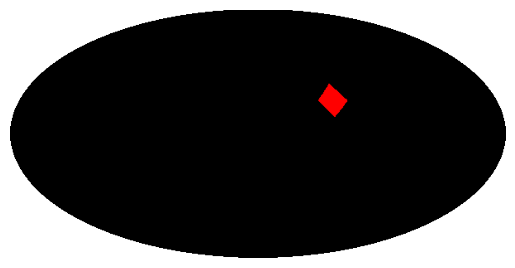

In [4]:
moc_test.display_preview()

Then, we write the MOC region in an external file named **TEST.fits** serialized in a FITS format.

In [5]:
moc_test.save(path / "TEST.fits", format="fits", overwrite=True)

**Figure 1.** HEALPix grid at order = 4. In red, the MOC region with HEALPix index = 652. This represents the MOC we created.

Now, we read the MOC file `TEST.fits` and we find the MOC order: the depth of the smallest HEALPix cells. Of course, we will find an order = 4 as set when we created the MOC.

In [6]:
# Read  MOC map.
moc_test_from_file = MOC.from_fits(path / "TEST.fits")

# Find MOC order
moc_order = moc_test_from_file.max_order
print("moc_order =", moc_order)

moc_order = 4


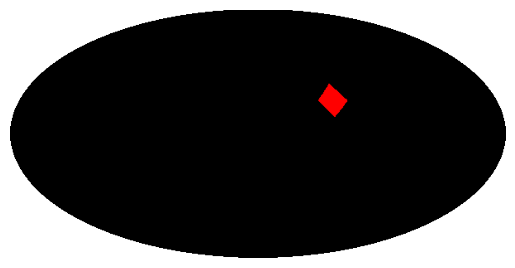

In [7]:
moc_test_from_file.display_preview()

Here, we serialize the MOC from fits to json/dictionary with the keys and values representing the orders and the pixel indices, respectively. Of course, we find here the values used in the original MOC creation.

In [8]:
# Serialize the MOC from fits to json/dict.
moc_json = moc_test.serialize(format="json")
moc_json

{'2': [50], '4': []}

By definition, for the [nested](https://healpix.jpl.nasa.gov/html/intronode4.htm) numbering scheme used in MOcs, the HEALPix cells of higher order contained in a cell are comprised between:

$[npix \times 4^{(max\_order - order)}]$ 

and

$[(npix+1) \times 4^{(max\_order - order)}-1] $.


In [9]:
first_index = int(ipix[0] * 4)
last_index = int((ipix[0] + 1) * 4 - 1)
print(
    f"For our cell {ipix[0]} at order {depth[0]}, the cells at "
    f"order {depth[0] +1} are comprised between the indices {first_index} and {last_index}",
)
moc_order_3 = MOC.from_healpix_cells(
    np.array([200, 201, 202, 203], dtype="uint64"),
    np.array([3, 3, 3, 3], dtype="uint8"),
    3,
)

For our cell 50 at order 2, the cells at order 3 are comprised between the indices 200 and 203


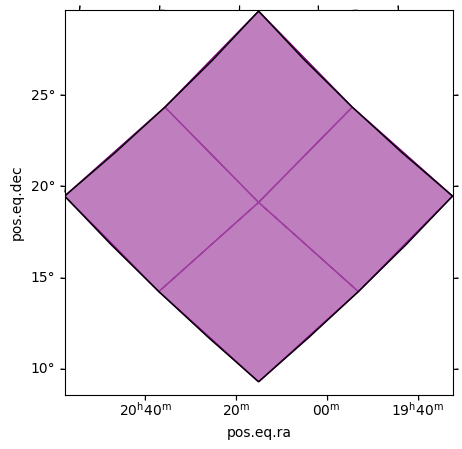

In [10]:
fig = plt.figure(figsize=(5, 5))
wcs = moc_order_3.wcs(fig)
ax = fig.add_subplot(projection=wcs)
# Represent the moc at order 3 with its four cells, 200, 201, 202, and 203
moc_order_3.fill(ax, wcs, color="purple", alpha=0.5)
moc_order_3.border(ax, wcs, color="purple")
# Reprensent the cell 50 at order 2
moc_test.border(ax, wcs, color="black")

You can interactively visualize the results with the following Aladin widget. To see the HealPix grid, select it in the `manage layers` <img src="https://github.com/ggreco77/Tutotest/blob/main/images/ipyaladin_layer.png?raw=true" alt="the Layer Button" style="width:30px; display: inline-block;"/> menu.

In [11]:
aladin = Aladin(target="20:15:0, +19:15:0", fov=150, height=600)
aladin

Aladin(fov=150.0, height=600.0, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'over…

A MOC map can also be added to the Aladin widget by adding it to the variable `aladin`:

In [12]:
aladin.add_moc_from_dict(
    moc_order_3.serialize(format="json"),
    {
        "color": "purple",
        "opacity": 0.4,
        "adaptativeDisplay": False,
        "name": "moc_order_3",
    },
)
# if the MOC does not appear right away in the ipyaladin widwet, unzoom and zoom again to actualize the view

## Astroplan

In this second section, we cover the use of [astroplan](https://astroplan.readthedocs.io/en/latest/index.html) a python library useful for observation planning and scheduling.

First, we want to define the airmass in each HEALPix index using the astroplan module. In particular, we define the airmass in the Haleakala site  at 2019-04-25 14:18:05.018 UTC.

In [13]:
# Let's define a MOC with four cells and extract the coordinates of the centers of these cells
healpix_indices = [2608, 2609, 2610, 2611]
observation_MOC = MOC.from_json({5: healpix_indices})
skycoords = healpix_to_skycoord(healpix_indices, 5)

# The Observer module has pre-defined observations sites. Here we chose Haleakala.
haleakala = Observer.at_site("haleakala")

# Set observational time.
start_time = Time("2019-04-25 12:30:00")

haleakala

<Observer: name='haleakala',
    location (lon, lat, el)=(-156.169 deg, 20.71552 deg, 3047.9999999999245 m),
    timezone=<UTC>>

Haleakala info from Observer class in astroplan.

In [14]:
print(
    f"""We could apply any of the methods listed here
 to the object haleakea {dir(haleakala)}""",
)

We could apply any of the methods listed here
 to the object haleakea ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_altitude_trig', '_calc_riseset', '_calc_transit', '_determine_which_event', '_horiz_cross', '_is_broadcastable', '_preprocess_inputs', '_two_point_interp', 'altaz', 'astropy_time_to_datetime', 'at_site', 'datetime_to_astropy_time', 'is_night', 'local_sidereal_time', 'location', 'midnight', 'moon_altaz', 'moon_illumination', 'moon_phase', 'moon_rise_time', 'moon_set_time', 'name', 'noon', 'parallactic_angle', 'pressure', 'relative_humidity', 'sun_altaz', 'sun_rise_time', 'sun_set_time', 'target_hour_angle', 'target_is_up', 'target_meridian_antitransit_time', 'target_meridian_tr

Does the time we set correspond to night time at Haleakala? You can answer it using [is_night](https://astroplan.readthedocs.io/en/latest/api/astroplan.Observer.html#astroplan.Observer.is_night) method and setting the astronomical twilight.

In [15]:
# Check if it is night in Haleakala at the defined time:
# -18 degree horizon (evening astronomical twilight).
night = haleakala.is_night(start_time, horizon=-18 * u.deg)
print("Is it night?", night)

Is it night? True


We have all needed information to calculate the airmass at the sky coordinates determined in the first section.

In [16]:
# Airmass calculation
airmass_values = haleakala.altaz(start_time, skycoords).secz

for airmass_value, skycoord in zip(airmass_values, skycoords):
    print(f"airmass: {airmass_value.round(2)} {skycoord} ")

airmass: 1.28 <SkyCoord (ICRS): (ra, dec) in deg
    (202.5, 31.38816646)> 
airmass: 1.27 <SkyCoord (ICRS): (ra, dec) in deg
    (203.90625, 32.7971683)> 
airmass: 1.31 <SkyCoord (ICRS): (ra, dec) in deg
    (201.09375, 32.7971683)> 
airmass: 1.29 <SkyCoord (ICRS): (ra, dec) in deg
    (202.5, 34.22886633)> 


To only select sky area with airmass < 1.30, we create a new MOC with those sky coordinates. We will call it `MOC_observability_haleakala`. 

It can be useful to create an astropy table with skycoords and airmass_values as columns. Then we filter the airmass_values column from 1.00 to 1.30. 

In [17]:
table = QTable([skycoords, airmass_values], names=["skycoords", "airmass_value"])

# Mask table with selected airmass values.
observability_table = table[
    (table["airmass_value"] >= 1.0) & (table["airmass_value"] <= 1.3)
]

observability_table

skycoords,airmass_value
"deg,deg",
SkyCoord,float64
"202.5,31.388166464348547",1.2833562530262468
"203.90625,32.797168295823646",1.265523826842467
"202.5,34.22886632781258",1.289875095057908


## Combining astroplan and STMOC

We use the [from_skycoords](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.from_skycoords) method of MOCpy to create an observability MOC from the sky coordinates.

In [18]:
# MOC from  sky coordinates
moc_observability_haleakala = MOC.from_skycoords(observability_table["skycoords"], 5)
moc_observability_haleakala

5/2608-2609 2611 

The MOC observability is shown in green in **Figure 3** over the original MOC. The HEALPix index = 2610 at order = 5 is not considered in the MOC visibility at the coordinates RA = 201.09375 $^\circ$, DEC = 32.7971683 $^\circ$. This is because its associated airmass value = 1.31 is outside the airmass range we selected to create the MOC visibility from Haleakala.

In [19]:
aladin2 = Aladin(target="13:30:0, +32:50:0", fov=150, height=600)

aladin2

Aladin(fov=150.0, height=600.0, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'over…

In [20]:
aladin2.add_moc_from_dict(
    observation_MOC.serialize(format="json"),
    {"color": "blue", "opacity": 0.5},
)
aladin2.add_moc_from_dict(
    moc_observability_haleakala.serialize(format="json"),
    {"color": "green", "opacity": 0.5, "fill": True},
)

In green, the MOC visibility from the Haleakala site with airmass ranges from 1.00 to 1.30 over the original MOC area in blue.

### Adding temporal information to an (Observability) MOC

The ability to transform any spatial MOC generated from telescope footprints, image surveys, catalogues, gravitational-wave sky localizations, MOC visibility *etc.* into spatial and temporal MOC (STMOC) offers several interoperable approaches. In the next sections, we will discuss how to filter candidate transients.

To encode temporal information in a space (observability) MOC, we apply the method [from_spatial_coverages](https://cds-astro.github.io/mocpy/stubs/mocpy.STMOC.html#mocpy.STMOC.from_spatial_coverages) from mocpy. We assume an exposure time of 10 minutes: from 2019-04-25 12:30:00 to 2019-04-25 12:40:00.

In [21]:
# Create a Space and Time MOC from a space MOC.
space_time_moc_obs = STMOC.from_spatial_coverages(
    Time(["2019-04-25 12:30:00"]),
    Time(["2019-04-25 12:40:00"]),
    [moc_observability_haleakala],
)

**Filtering transient candidates**

To filter transient candidates *in space and in time* simultaneously, we use the [contains](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.contains) method in mocpy. It returns a boolean mask array of the positions lying inside (or outside) the MOC instance. Good performances are obtained thanks to the core functions written in Rust programming language.  

We consider two transients at sky positions of
-  transient1: (RA = 202.49997 $^\circ$, DEC = 32.79846 $^\circ$) observed at UTC time 2019-04-25T12:33:00
-  transient2: (RA = 202.69392 $^\circ$, DEC = 34.02011 $^\circ$) observed at UTC time 2019-04-25T12:50:00

Both candidate transients fall inside our MOC region but only the first one is consistent with the exposure time of that region, see next cells: 

In [22]:
# An astropy table with the 2 transients is created.
transient_tb = QTable()

# ID candidate transients
transient_tb["ID"] = ["transient1", "transient2"]

# Transient positions
transient_tb["ra"] = [202.49997, 202.69392] * u.deg
transient_tb["dec"] = [32.79846, 34.02011] * u.deg

# Transient time observations
transient_tb["time"] = Time(["2019-04-25T12:33:00", "2019-04-25T13:45:00"])

print(transient_tb)

    ID         ra      dec              time         
              deg      deg                           
---------- --------- -------- -----------------------
transient1 202.49997 32.79846 2019-04-25T12:33:00.000
transient2 202.69392 34.02011 2019-04-25T13:45:00.000


In [23]:
# Filtering transients in space and time.
space_time_moc_obs.contains(
    transient_tb["time"],
    transient_tb["ra"],
    transient_tb["dec"],
)

array([ True, False])

As expected,  the boolean mask returns **True** only for the transient1.

## Concrete example : planning observations for a GW follow up

Here we describe the essential steps to delimit portions of a MOC coverage that are observable from a specific astronomical site within a fixed time interval and a defined range of airmass values. We start with the 90% credible region of the gravitational-wave event GW190425. The credible region is encoded in a MOC data structure. In order to show the potential of MOCs to manage complex and irregular sky areas, the 90% credible region of GW190425 is prepocessed as discussed in **Sections 4.2 and 4.3**.
The MOC region is accessible from the link [here](https://github.com/ggreco77/MOC-to-plan-MMA/blob/main/data/processed_moc_skymap.fits?raw=true). 
All steps are shown in the [video tutorial](https://virgo.pg.infn.it/sites/virgo.pg.infn.it/files/mm/tuto_A_C_mid.mp4) focusing in the main Aladin graphical user interface. 

For running the code, we consider the merger time of GW190425 from the image's header.

In [24]:
# Download the initial (BAYESTAR)sky map of GW190425 from GraceDB.

bayesian = download_file(
    "https://gracedb.ligo.org/api/superevents/S190425z/files/bayestar.fits.gz,0",
    cache=True,
)

In [25]:
# Get merger time from image's header.
hdul = fits.open(bayesian)
merger_time = Time(hdul[1].header["DATE-OBS"])

print("The merger time is", merger_time)

The merger time is 2019-04-25T08:18:05.018


In [26]:
# Define an observatory from the astroplan list
observatory_name = "haleakala"

In [27]:
# Define observatory in the astroplan Observer class
observatory_astroplan_observer = Observer.at_site(observatory_name)

In [28]:
observatory_astroplan_observer

<Observer: name='haleakala',
    location (lon, lat, el)=(-156.169 deg, 20.71552 deg, 3047.9999999999245 m),
    timezone=<UTC>>

In [29]:
# Check if it is night in your Observatory at the merger time:
# -18 degree horizon (evening astronomical twilight).
night = observatory_astroplan_observer.is_night(merger_time, horizon=-18 * u.deg)

In [30]:
print(f"Is nightime in {observatory_name} ?", night)

Is nightime in haleakala ? True


If it is night in your observatory, we set as start time the merger time of the event, otherwise, we find the nearest twilight astronomical evening. 

In [31]:
if night:  # starts as soon as the merger if it is nightime at the observatory
    start_time = merger_time
else:
    # else, wait for the nearest twilight astronomical evening
    twilight_evening_astronomical = (
        observatory_astroplan_observer.twilight_evening_astronomical(
            merger_time,
            which="nearest",
        )
    )
    start_time = twilight_evening_astronomical

In [32]:
print("Start time for the first observation:", start_time)

Start time for the first observation: 2019-04-25T08:18:05.018


In [33]:
# Init. list for schedule observation
observatory_time_obs = []
# Set the airmass range to create the MOC visibility
airmass_max = 2
airmass_min = 1
# Read the MOC map.
moc = MOC.from_fits(path / "processed_moc_skymap.fits")
# Find MOC Order
order = moc.max_order
print("MOC order:", order)

MOC order: 11


Here, we want to calculate the visibility area within the previous MOC from the specific observatory site, at a given time and setting the airmass values.

In [34]:
# Serialize the MOC from fits to json/dict.
moc_json = moc.serialize(format="json")
# Init. a list of HEALPix indices.
healpix_indices = []
# Set a MOC order. MOC order >= max order in the original MOC.
input_order = order
print("input_order: ", input_order)
# Read MOC JSON file.
for key, value in moc_json.items():
    order = int(key)

    # Flatten cells.
    for npix in value:
        first_index = npix * 4 ** (input_order - order)
        last_index = (npix + 1) * 4 ** (input_order - order) - 1

        # Resulting list of flatten cells.
        for healpix_index in np.arange(first_index, last_index + 1):
            healpix_indices.append(healpix_index)
healpix_indices[:10]

input_order:  11


[8388608,
 8388609,
 8388610,
 8388611,
 8388612,
 8388613,
 8388614,
 8388615,
 8388616,
 8388617]

In [35]:
# Convert HEALPix indices to celestial coordinates.
healpix_indices = np.array(healpix_indices)
skycoord = healpix_to_skycoord(healpix_indices, input_order)

In the next cell, we open a samp instance with the function defined at the beginning of this notebook. This protocol will try to send information to the Aladin desktop application to vizualize the observation plan. Be sure that the application is open. 

To install the aladin desktop software, follow the instructions below.

Download the Aladin.jar from the Aladin download page. Execute it from a terminal by typing:

`$ java -Xmx2g -jar Aladin.jar`

The flag -Xmx specifies the maximum memory allocation pool for a JVM. Here 2GB of memory is allocated. For GW sky localizations with nside=2048, increase the memory allocated up to 3GB, -Xmx3g.

In [36]:
def get_observation_moc(start_time, after_n_hours: int, observer):
    """Get an observation MOC from observer point of view n-hours after start-time.

    This MOC corresponds to a sky area above the horizon (above 18°) and with an
    airmass comprised between 1 and 2.

    Parameters
    ----------
    start_time : `astropy.time.core.Time`
        Time at which the observation starts
    after_n_hours : int
        Increment for the time, in hours
    observer : `astroplan.observer.Observer`
        An observatory, as defined in astroplan

    Returns
    -------
    `mocpy.moc.moc.MOC`
        The corresponding MOC
    """
    time_step = start_time + timedelta(hours=after_n_hours)
    night = observer.is_night(time_step, horizon=-18 * u.deg)
    print(f"Was it nightime in {observatory_name} at {time_step.iso}? ", night)

    # Airmass calculation
    airmass = observatory_astroplan_observer.altaz(time_step, skycoord).secz

    # Create an Astropy table.
    tb = QTable([skycoord, airmass], names=["skycoord", "airmass"])

    # Mask table with selected airmass values.
    tb = tb[(tb["airmass"] >= airmass_min) & (tb["airmass"] <= airmass_max)]

    # Create an observability MOC.
    return MOC.from_skycoords(tb["skycoord"], input_order)

In [37]:
observation_aladin = Aladin(fov=200, target="20:00:0, +20:00:0", height=600)
observation_aladin

Aladin(fov=200.0, height=600.0, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'over…

In [38]:
list_moc = []
for increment_hour in range(0, 8, 2):
    spacial_moc = get_observation_moc(
        start_time,
        increment_hour,
        observatory_astroplan_observer,
    )
    # we add the MOCs here
    observation_aladin.add_moc_from_dict(
        spacial_moc.serialize(format="json"),
        {
            "opacity": 0.5,
            "name": f"observation_after_{increment_hour}_hours",
            "fill": True,
        },
    )
    list_moc += [spacial_moc]

Was it nightime in haleakala at 2019-04-25 08:18:05.018?  True
Was it nightime in haleakala at 2019-04-25 10:18:05.018?  True
Was it nightime in haleakala at 2019-04-25 12:18:05.018?  True
Was it nightime in haleakala at 2019-04-25 14:18:05.018?  True


Explote the aladin view to see the mocs, or plot them directly with matplotlib. The list of MOCs behaves like every other list, and you could for example retrieve the first MOC we created with `list_moc[0]`

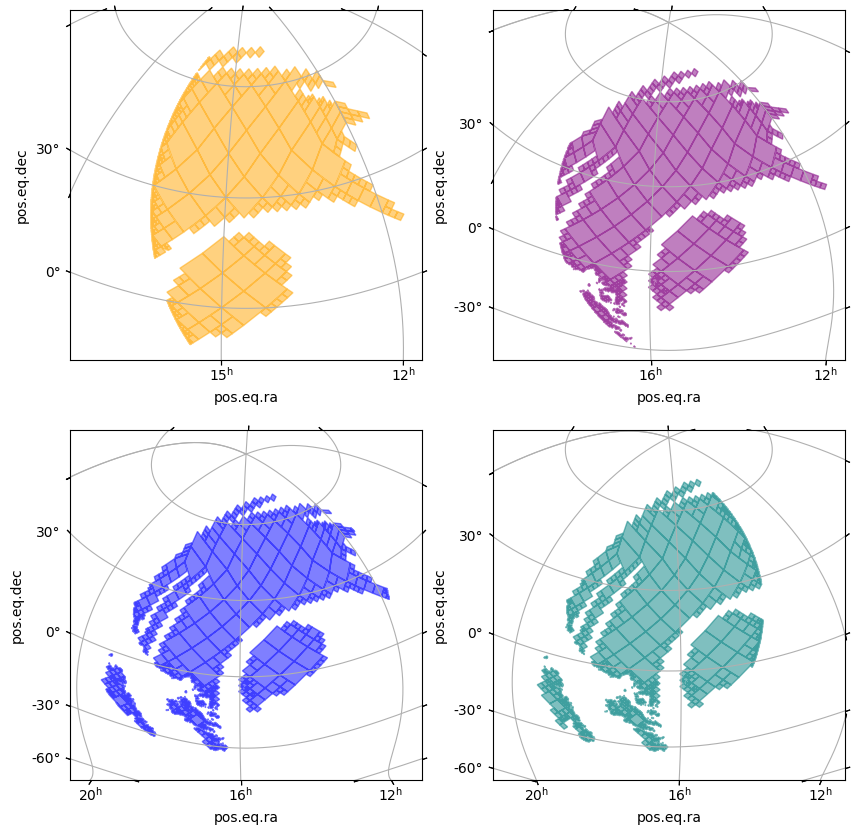

In [39]:
fig = plt.figure(figsize=(10, 10))
colors = ["orange", "purple", "blue", "teal"]

for i, moc in enumerate(list_moc):
    wcs = moc.wcs(fig)
    ax = fig.add_subplot(
        2,
        2,
        i + 1,
        projection=wcs,
    )  # a 2*2 grid of subplots
    moc.fill(ax, wcs, fill=True, alpha=0.5, color=colors[i])
    ax.grid(True)  # noqa: FBT003

Both the visualisations in aladin and with the display_preview allow to see the evolution of the observation area with time. Feel free to check and uncheck the coverages display in the aladin widget in the `Manage Layers` menu.
Then, we repeat the same steps for Paranal and SSO observatories fixing the same starting time than for the Haleakala site.

In [40]:
# Set Observers: Paranal and SSO
paranal = Observer.at_site("paranal")
sso = Observer.at_site("sso")
print(paranal)
print(sso)

<Observer: name='paranal',
    location (lon, lat, el)=(-70.40498688000002 deg, -24.627439409999997 deg, 2668.999999999649 m),
    timezone=<UTC>>
<Observer: name='sso',
    location (lon, lat, el)=(149.06119444444445 deg, -31.273361111111104 deg, 1149.0000000015516 m),
    timezone=<UTC>>


**An updated list of built-in observatories can be found in [astropy-data/coordinates/sites.json](https://github.com/astropy/astropy-data/blob/162e724509fd18b8bc3fc29f766b716ce4657d20/coordinates/sites.json)**